In [189]:
import sys
import plotly.graph_objects as go
sys.path.append("..") 
from orm.mongo_client import FoodMongoClient
import matplotlib.pyplot as plt
import numpy as np
import pprint
from sklearn.decomposition import PCA

### Визуализация распределений

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from yellowbrick.text import FreqDistVisualizer
from nltk import word_tokenize
import nltk
nltk.download('punkt')

with FoodMongoClient() as mngcl:
    recipes = mngcl.find_all('recipes')
    ingredients_data = mngcl.find_all('ingredients')
    tags_data = mngcl.find_all('tags')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vadimkozyrevskii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Ингредиенты

Используются все ингредиенты с частотой, принимающей значения [44, 445]


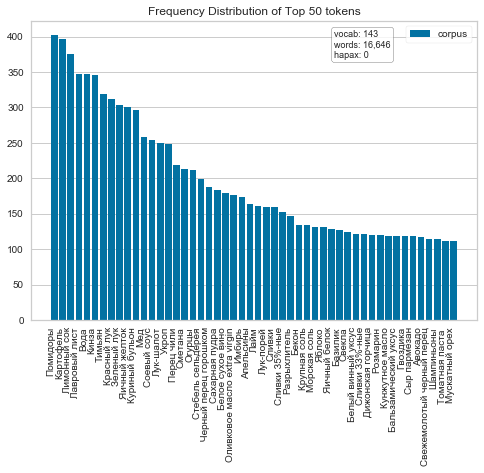

In [191]:
ingredients_k2v = dict([(ingr['id'], ingr['name']) for ingr in ingredients_data])
ingredients = [' '.join(list(map(lambda x: str(x['id']), recipe['ingredients']))) for recipe in recipes]

ingr_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
ingr_docs = ingr_vectorizer.fit_transform(ingredients)

ingr_vocab = list(map(lambda x: x, ingr_vectorizer.get_feature_names()))

ingr_counts = ingr_docs.sum(axis=0).A1
ingr_freq_distribution = Counter(dict(zip(ingr_vocab, ingr_counts)))

ingr_destr = sorted(list(ingr_freq_distribution.items()), key=lambda x : x[1], reverse=True)

lowwer_eps = 0.01
upper_eps = 0.9

print(f'Используются все ингредиенты с частотой, принимающей значения [{round(len(ingredients) * lowwer_eps)}, '
      f'{round(len(ingredients) * (1 - upper_eps))}]')

ingr_destr = [item for item in ingr_destr if item[1] >= round(len(ingredients) * lowwer_eps) and 
                                              item[1] <= round(len(ingredients) * (1 - upper_eps))]

supported_ingr = list(map(lambda x: x[0], ingr_destr))

clear_ingredients = [' '.join(list(map(lambda x: str(x['id']) if str(x['id']) in supported_ingr 
                                                               else '', recipe['ingredients']))) 
                     for recipe in recipes]

ingr_vectorizer = CountVectorizer()
ingr_docs = ingr_vectorizer.fit_transform(clear_ingredients)
ing_features = list(map(lambda x: ingredients_k2v[int(x)], ingr_vectorizer.get_feature_names()))

ingr_vectorizer = FreqDistVisualizer(features=ing_features, orient='v', n=50)
ingr_vectorizer.fit(ingr_docs)
ingr_vectorizer.show()

#### Теги

Используются все теги с частотой, принимающей значения [4, 1334]


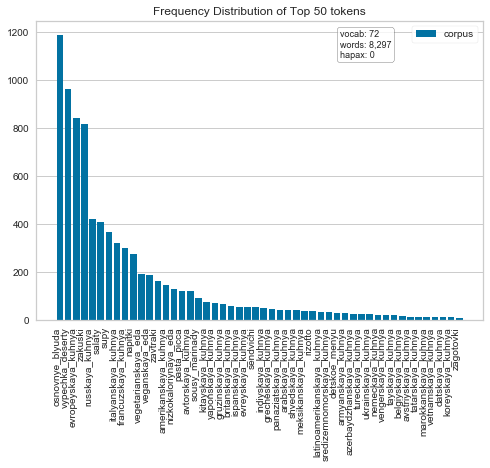

In [192]:
tags_k2v = dict([(tag['id'], tag['name']) for tag in tags_data])
tags = [' '.join(list(map(lambda x: x.replace('-', '_'), recipe['tags']))) for recipe in recipes]

tags_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
tags_docs = tags_vectorizer.fit_transform(tags)

tags_vocab = list(map(lambda x: x, tags_vectorizer.get_feature_names()))

tags_counts = tags_docs.sum(axis=0).A1
tags_freq_distribution = Counter(dict(zip(tags_vocab, tags_counts)))

tags_destr = sorted(list(tags_freq_distribution.items()), key=lambda x : x[1], reverse=True)

lowwer_eps = 0.001
upper_eps = 0.7

print(f'Используются все теги с частотой, принимающей значения [{round(len(tags) * lowwer_eps)}, '
       f'{round(len(tags) * (1 - upper_eps))}]')

tags_destr = [item for item in tags_destr if item[1] >= round(len(tags) * lowwer_eps) and 
                                              item[1] <= round(len(tags) * (1 - upper_eps))]

supported_tags = list(map(lambda x: x[0], tags_destr))

clear_tags = [' '.join(list(map(lambda x: x.replace('-', '_') if x.replace('-', '_') in supported_tags 
                                else '', recipe['tags']))) 
              for recipe in recipes]

tags_vectorizer = CountVectorizer()
tags_docs = tags_vectorizer.fit_transform(clear_tags)
tags_features = tags_vectorizer.get_feature_names()

tags_vectorizer = FreqDistVisualizer(features=tags_features, orient='v', n=50)
tags_vectorizer.fit(tags_docs)
tags_vectorizer.show()


In [193]:
pprint.pprint(tags_docs.toarray().shape)

(4448, 72)


In [194]:
tags_k2v = {}
ingredients_k2v = {}
dataset = []
with FoodMongoClient() as mngcl:
    tags = mngcl.find_all('tags')
    ingredients = mngcl.find_all('ingredients')
    recepes = mngcl.find_all('recipes')
    recepes_k2v = dict([(rec['id'], rec['name']) for rec in recepes])
    recepes_v2k = dict([(rec['name'], rec['id']) for rec in recepes])
    recipe_ids = []
    for rec in recepes:
        dataset.append(' '.join([tag for tag in rec['tags'] if tag.replace('-', '_') in supported_tags] +  
                     [str(ing['id']) for ing in rec['ingredients'] if str(ing['id']) in supported_ingr]))
        recipe_ids.append(str(rec['id']))

In [195]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
bags_of_words = CountVectorizer().fit_transform(dataset).toarray()
svd = TruncatedSVD(n_components=16, n_iter=128, random_state=777).fit_transform(bags_of_words)

In [196]:
recipe_vectors = svd
print(recipe_vectors.shape)
recipe_pca_vectors = PCA(n_components=2).fit_transform(recipe_vectors)
fig = go.Figure(data=go.Scatter(x=recipe_pca_vectors[:, 0],
                        y=recipe_pca_vectors[:, 1],
                        mode='markers',
                        text=list(map(lambda x: recepes_k2v[x], recipe_ids)))) # hover text goes here
fig.update_layout(title=f'Recipes')
fig.show()

(4448, 16)


In [198]:
tree_id2rec_key = dict([(i, recipe) for i, recipe in enumerate(recipe_ids)])
rec_key2tree_id = dict([(recipe, i) for i, recipe in enumerate(recipe_ids)])

rec_name2tree_id = dict([(recepes_k2v[recipe], i) for i, recipe in enumerate(recipe_ids)])
tree_id2rec_name = dict([(i, recepes_k2v[recipe]) for i, recipe in enumerate(recipe_ids)])

In [201]:
from sklearn.cluster import DBSCAN

recipe_names = [
    'Долма',
    'Хинкали',
    'Торт «Красный бархат» от\xa0Andy Chef',
    'Традиционный торт «Наполеон»',
    'Торт «Прага»',
    'Торт «Сметанник»',
    'Торт «Муравейник»',
    'Пицца «Маргарита» Вальтера Бизоффи',
    'Чикагская пицца'
]

#list(rec_name2tree_id.keys())[:100]

vectors = list(map(lambda x: svd[rec_name2tree_id[x]], recipe_names))

from sklearn.cluster import DBSCAN
import pprint
clustering = DBSCAN(eps=1, min_samples=2).fit(vectors)
clusters_set = set(clustering.labels_)

#pprint.pprint(sorted(list(zip(recipe_names, clustering.labels_)), key=lambda x: x[1]))

data_for_recomendations = dict(zip(clusters_set, [
    [rec for i, rec in enumerate(recipe_names) if clustering.labels_[i] == label] for label in clusters_set]))

pprint.pprint(data_for_recomendations)

{-1: ['Долма', 'Хинкали', 'Торт «Прага»'],
 0: ['Торт «Красный бархат» от\xa0Andy Chef',
     'Традиционный торт «Наполеон»',
     'Торт «Сметанник»',
     'Торт «Муравейник»'],
 1: ['Пицца «Маргарита» Вальтера Бизоффи', 'Чикагская пицца']}


In [204]:
from sklearn.neighbors import KDTree
from operator import itemgetter
tree = KDTree(recipe_vectors, leaf_size=2)

recomendations = {}

for label, names in data_for_recomendations.items():
    if label == -1: continue
    
    
    dist, ind = tree.query(
        [
            np.mean(
                list(map(lambda x: recipe_vectors[rec_name2tree_id[x]], names))
                , axis=0)
        ], k=20)
    
    keys = itemgetter(*ind[0])(tree_id2rec_key)
    values = itemgetter(*ind[0])(tree_id2rec_name)
    
    recomendations[label] = list(zip(keys, values))
    

pprint.pprint(recomendations)

{0: [('36156', 'Атайеф'),
     ('28444', 'Оладьи из\xa0кабачков с\xa0зеленью'),
     ('126179', 'Беляши'),
     ('125960', 'Пиде с\xa0тремя видами сыра'),
     ('137633', 'Симит'),
     ('93844', 'Имеретинский мини-хачапури'),
     ('31492', 'Чешская булочка трдло'),
     ('27289', 'Творожный пирог со\xa0сливочным сыром'),
     ('27289', 'Творожный пирог со\xa0сливочным сыром'),
     ('93455', 'Содовый хлеб'),
     ('93455', 'Содовый хлеб'),
     ('114399', 'Олиболы'),
     ('50649', 'Берлинер'),
     ('31031', 'Змеиный пирог'),
     ('94098', 'Канельбуллар (Булочки с\xa0корицей)'),
     ('94104', 'Брюсселькекес (Брюссельские печенья)'),
     ('94104', 'Брюсселькекес (Брюссельские печенья)'),
     ('42998', 'Шоколадный пудинг с\xa0темным шоколадом'),
     ('125115', 'Гибаница'),
     ('125115', 'Гибаница')],
 1: [('22835', 'Тонкое тесто для\xa0пиццы'),
     ('20756', 'Зеленые равиоли с\xa0тыквой и\xa0соусом из\xa0шалфея'),
     ('137410', 'Чикагская пицца'),
     ('35393', 'Пицца «Марг